# AIDL Project - License Plate Detection and Image Deblurring 

## Flow of the project:
1. Taking a high-resolution image of a car as the input image.
2. Detecting the number plate in the image and creating a bounding box
3. Extracting the license number from the number plate using pytesseract
4. Saving the image of number plate and make it an input image for the image deblurring
5. Adding a noise/blur to the image
6. Recovering the pixels or image details by using SRCNN 

##### Research Paper Referred: https://www.researchgate.net/publication/221364186_Image_super-resolution_as_sparse_representation_of_raw_image_patches by Jianchao Yang, John Wright, Thomas S. Huang, and Yi Ma.

## Installing Libraries

In [1]:
#!pip install pytesseract
#!pip install imutils
#!pip install opencv
#!pip install tqdm
#!pip install torch
#!pip install torchvision
#!pip install scikit-learn
#!pip install matplotlib
#!pip install pillow

## Importing Packages

In [2]:
import cv2
import imutils
import numpy as np
import pytesseract

import os
from tqdm import tqdm
import shutil

import matplotlib.pyplot as plt
import glob

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import argparse

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from PIL import Image

# PART A: License Plate Detection

## Reading the file 

In [3]:
# Setting the path to Tesseract OCR executable
# pytesseract is a Python wrapper for Google's Tesseract-OCR Engine (Optical Character Recognition), which is used here for text recognition
# The line of code configures the pytesseract library to use Tesseract OCR from the specified location
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

# Loading the image using OpenCV
# cv2.imread() function reads an image from the specified file path
# The first argument is the path to the image file
# The second argument specifies the image read mode, in this case, cv2.IMREAD_COLOR reads the image in color
img = cv2.imread("D:\\Final Project\\New folder\\input\\sharp\\1ca1155083156d72_jpg.rf.f69458ccf7481ccdd8833b28b4a83f7a.jpg",cv2.IMREAD_COLOR)

## Finding contours
##### Contours are essentially the boundaries of regions with similar intensity or color in the image
##### These contours can be analyzed further to identify and characterize objects or regions of interest within the image

In [4]:
img = cv2.resize(img, (600,400) ) # Resize the input image to the dimensions

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert the resized image to grayscale
gray = cv2.bilateralFilter(gray, 13, 15, 15) # Apply bilateral filter to the grayscale image to reduce noise while preserving edges

edged = cv2.Canny(gray, 30, 200) # Detect edges in the grayscale image using Canny edge detection

# Finding contours in the edged image
contours = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # cv2.findContours() returns three values: contours, hierarchy, where we're interested only in contours
contours = imutils.grab_contours(contours) # Extract the contours using the imutils helper function
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None # Initialize a variable to hold the contour of the screen

## Detecting and Printing the Bounding Box on the image

In [5]:
for c in contours:
    
    peri = cv2.arcLength(c, True) # Calculate the perimeter of the contour
    # Approximating the polygonal curve of the contour using the Ramer-Douglas-Peucker algorithm
    # The parameter 0.018 * peri determines the approximation accuracy
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)

    # If the number of vertices in the polygonal approximation is 4, it is considered as a potential contour of interest
    if len(approx) == 4: #Square or Rectangle
        screenCnt = approx # Store the contour as screenCnt
        break

if screenCnt is None:
    detected = 0
    print ("No contour detected")
else:
     detected = 1

# If a contour is detected (detected = 1),contour on the image will be drawn 
if detected == 1:
    cv2.drawContours(img, [screenCnt], -1, (0, 0, 255), 3) # 3 is the thickness of the contour in pixels, (0,0,255) represents the Red Color

## Mask Creation

In [6]:
# Creating a mask with zeros of the same shape as the input grayscale image
mask = np.zeros(gray.shape,np.uint8)

# Drawing contours on the mask based on the detected screen contour (screenCnt)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)

# Performing bitwise AND operation between the input image (img) and the mask to extract the region of interest containing the license plate
new_image = cv2.bitwise_and(img,img,mask=mask)

# Finding the coordinates of the non-zero (white) pixels in the mask
(x, y) = np.where(mask == 255)

# Determine the top-left (topx, topy) and bottom-right (bottomx, bottomy) coordinates of the bounding box surrounding the detected license plate
(topx, topy) = (np.min(x), np.min(y)) #TOP-LEFT Corner 
(bottomx, bottomy) = (np.max(x), np.max(y)) #BOTTOM-RIGHT Corner

# Cropping the grayscale image based on the determined bounding box coordinates
Cropped = gray[topx:bottomx+1, topy:bottomy+1]

# Performing Optical Character Recognition (OCR) on the cropped image using Tesseract with page segmentation mode (psm) set to 11
# Sparse text with OSD (Orientation and Script Detection)
text = pytesseract.image_to_string(Cropped, config='--psm 11')

# Printing the detected license plate number
print("Detected license plate Number is:",text)

#Resizing for display
img = cv2.resize(img,(500,300))
Cropped = cv2.resize(Cropped,(400,200))

Detected license plate Number is: OUTSTDN



# PART B: Image Deblurring 

#### Image Deblurring: 
The goal of image deblurring is to improve the quality of low-resolution images by restoring details and reducing blur/noise, ultimately producing high-resolution versions of the input images. The HR images are also referred to as Ground Truth.

In [7]:
# Making directories to store output images 
os.makedirs('../input/gaussian_blurred', exist_ok=True)
os.makedirs('../input/sharp', exist_ok=True)

# Setting the source directory path where the image will be saved
src_dir = '../input/sharp'

# Saving an image named 'number_plate.jpg' in the 'src_dir' directory.
cv2.imwrite(src_dir + "/number_plate.jpg", Cropped) #Cropped image will be the Sharp image/HR image/Ground Truth
images = os.listdir(src_dir)

# Setting the destination directory path where the blurred images will be saved
dst_dir = '../input/gaussian_blurred'

#Printing the total number of images 
print(len(images))

1


#### For random images from a image dataset 
Source of Dataset for License Plate Image: 
Kaggle: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection
Roboflow: https://public.roboflow.com/object-detection/license-plates-us-eu


In [8]:
#Creating dataset of replicas of the cropped image to create the training dataset for the Sharp Image as training can't be performed on a single image
iterations = 850 #Number of duplicate images to be created

def replicate_image(input_image_path, src_dir, images, iterations):
    for iteration in range(iterations):
        output_image_path = os.path.join(src_dir, f"{iteration}_{images[0]}")
        shutil.copyfile(input_image_path, output_image_path)
        #print(f"Replicated image {iteration+1} copied to {output_image_path}")

input_image_path = os.path.join(src_dir, images[0])
replicate_image(input_image_path=input_image_path, src_dir=src_dir, images=images, iterations=iterations)
images = os.listdir(src_dir)

In [9]:
# The below code loads each image using OpenCV, applies Gaussian blurring to the image, and saves the blurred image to a destination directory
for i, img in tqdm(enumerate(images), total=len(images)):
    if ".ipynb_checkpoints" != images[i]:
        img = cv2.imread(f"{src_dir}/{images[i]}", cv2.IMREAD_COLOR)
        #print(images[i])
        # Adding Gaussian blur to the image with a kernel size of (31, 31)
        blur = cv2.GaussianBlur(img, (31, 31), 0)
        # Write the blurred image to the destination directory after each iteration
        cv2.imwrite(f"{dst_dir}/{images[i]}", blur)
print('DONE')

100%|████████████████████████████████████████████████████████████████████████████████| 851/851 [00:14<00:00, 56.85it/s]

DONE


In [10]:
#Function to save the decoded image
def save_decoded_image(img, name):
    img = img.view(img.size(0), 3, 224, 224)
    save_image(img, name)

In [11]:
# helper functions
image_dir = '../outputs/saved_images' #Output directory
os.makedirs(image_dir, exist_ok=True)

# Checking if CUDA (GPU) is available, if available, using it, otherwise using CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 2

cpu


In [12]:
# Two lists, x_blur and y_sharp, are created to store filenames from the respective directories.
gauss_blur = os.listdir('../input/gaussian_blurred')
gauss_blur.sort()
sharp = os.listdir('../input/sharp')
sharp.sort()
x_blur = []
for i in range(len(gauss_blur)):
    x_blur.append(gauss_blur[i])
y_sharp = []
for i in range(len(sharp)):
    y_sharp.append(sharp[i])

print(len(x_blur))
print(len(y_sharp))

851
851


# Training and Testing

In [13]:
# The following code is splitting the data into training and validation sets using the train_test_split function from sklearn.

# train_test_split() function splits the dataset into two subsets: training set and validation set.
# x_blur: Input data (e.g., images) that may have undergone some blurring.
# y_sharp: Corresponding target labels (e.g., image labels) which are considered as sharp images.
# test_size=0.25: Specifies that 25% of the data will be used for validation, while the remaining 75% will be used for training.

# It returns four arrays:
# x_train: Training data instances (e.g., blurry images) after splitting.
# x_val: Validation data instances (e.g., blurry images) after splitting.
# y_train: Corresponding training target labels (e.g., sharp images) after splitting.
# y_val: Corresponding validation target labels (e.g., sharp images) after splitting.
(x_train, x_val, y_train, y_val) = train_test_split(x_blur, y_sharp, test_size=0.25)
print(f"Train data instances: {len(x_train)}")
print(f"Validation data instances: {len(x_val)}")

Train data instances: 638
Validation data instances: 213


In [14]:
# preprocessing images, ensuring compatibility for neural networks and improving performance
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [15]:
# Defining a custom dataset class named DeblurDataset inheriting from Dataset class.
class DeblurDataset(Dataset):
    def __init__(self, blur_paths, sharp_paths=None, transforms=None):
        self.X = blur_paths
        self.y = sharp_paths
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        blur_image = cv2.imread(f"../input/gaussian_blurred/{self.X[i]}")
        
        if self.transforms:
            blur_image = self.transforms(blur_image)
            
        if self.y is not None:
            sharp_image = cv2.imread(f"../input/sharp/{self.y[i]}")
            sharp_image = self.transforms(sharp_image)
            return (blur_image, sharp_image)
        else:
            return blur_image

In [16]:
train_data = DeblurDataset(x_train, y_train, transform)
val_data = DeblurDataset(x_val, y_val, transform)

# Creating a DataLoader for the training dataset and shuffling image after every epoch
# DataLoader is a utility provided by PyTorch to load data in batches during training
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [17]:
# Defining a custom neural network class called DeblurCNN, which is a subclass of nn.Module
# Defining a CNN model (DeblurCNN) for image deblurring using PyTorch
# Padding in convolutional neural networks refers to the addition of extra pixels around the input image before applying the convolution operation. 
# The model consists of three convolutional layers (conv1, conv2, conv3) followed by ReLU activations. 
class DeblurCNN(nn.Module):
    def __init__(self):
        super(DeblurCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, padding=2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=2)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x
model = DeblurCNN().to(device)
print(model)

DeblurCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [18]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) #Adam Optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
        optimizer,
        mode='min', # Monitor for reduction based on minimum validation loss
        patience=5, # Number of epochs to wait before reducing learning rate
        factor=0.5, # Factor by which the learning rate will be reduced
        verbose=True
    ) #Learning Rate Scheduler 

C:\Users\Tanvi Mathur\Desktop\Final Project\venv\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [19]:
def fit(model, dataloader, epoch):
    model.train() #Training mode
    running_loss = 0.0
    # tqdm is used to create a progress bar for visualization
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        blur_image = data[0]
        sharp_image = data[1]
        blur_image = blur_image.to(device) # Input blurred image
        sharp_image = sharp_image.to(device) # Target sharp image
        optimizer.zero_grad()
        outputs = model(blur_image) #Predicted outputs
        # Computing the loss between predicted outputs and target images
        loss = criterion(outputs, sharp_image)
        loss.backward()
        # update the parameters
        optimizer.step()
        # Accumulating the running loss
        running_loss += loss.item()
    
    train_loss = running_loss/len(dataloader.dataset) #Average training loss
    print(f"Train Loss: {train_loss:.5f}")
    
    return train_loss

## Model Evaluation

In [20]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            blur_image = data[0]
            sharp_image = data[1]
            blur_image = blur_image.to(device)
            sharp_image = sharp_image.to(device)
            outputs = model(blur_image)
            loss = criterion(outputs, sharp_image)
            running_loss += loss.item()
            
            if epoch == 0 and i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(sharp_image.cpu().data, name=f"../outputs/saved_images/sharp{epoch}.jpg")
                save_decoded_image(blur_image.cpu().data, name=f"../outputs/saved_images/blur{epoch}.jpg")
            
            if i == int((len(val_data)/dataloader.batch_size)-1):
                save_decoded_image(outputs.cpu().data, name=f"../outputs/saved_images/val_deblurred{epoch}.jpg")

        #Average Validation Loss
        val_loss = running_loss/len(dataloader.dataset)
        print(f"Val Loss: {val_loss:.5f}")
        
        return val_loss

In [21]:
# Initializing empty lists to store training and validation losses for each epoch
train_loss  = []
val_loss = []
# Recording the starting time to measure the total training time
start = time.time()
epochs=70
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, trainloader, epoch) # Calculate the training loss for the current epoch using the fit function
    val_epoch_loss = validate(model, valloader, epoch) # Calculate the validation loss for the current epoch using the validate function
    train_loss.append(train_epoch_loss) # Append the training loss of the current epoch to the list of training losses
    val_loss.append(val_epoch_loss) # Append the validation loss of the current epoch to the list of validation losses
    scheduler.step(val_epoch_loss)
# Recording the ending time to calculate the total training time
end = time.time()
print(f"Took {((end-start)/60):.3f} minutes to train")

Epoch 1 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:57<00:00,  2.70it/s]


Train Loss: 0.00887


107it [00:22,  4.82it/s]                                                                                               


Val Loss: 0.00246
Epoch 2 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:54<00:00,  2.80it/s]


Train Loss: 0.00204


107it [00:15,  7.12it/s]                                                                                               


Val Loss: 0.00171
Epoch 3 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:13<00:00,  2.39it/s]


Train Loss: 0.00147


107it [00:16,  6.32it/s]                                                                                               


Val Loss: 0.00116
Epoch 4 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:10<00:00,  2.44it/s]


Train Loss: 0.00131


107it [00:15,  6.85it/s]                                                                                               


Val Loss: 0.00095
Epoch 5 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:56<00:00,  2.75it/s]


Train Loss: 0.00099


107it [00:13,  7.77it/s]                                                                                               


Val Loss: 0.00076
Epoch 6 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.90it/s]


Train Loss: 0.00080


107it [00:13,  7.82it/s]                                                                                               


Val Loss: 0.00065
Epoch 7 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.92it/s]


Train Loss: 0.00080


107it [00:13,  7.75it/s]                                                                                               


Val Loss: 0.00085
Epoch 8 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.95it/s]


Train Loss: 0.00064


107it [00:14,  7.33it/s]                                                                                               


Val Loss: 0.00054
Epoch 9 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.98it/s]


Train Loss: 0.00057


107it [00:13,  8.17it/s]                                                                                               


Val Loss: 0.00060
Epoch 10 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.94it/s]


Train Loss: 0.00053


107it [00:14,  7.63it/s]                                                                                               


Val Loss: 0.00063
Epoch 11 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.91it/s]


Train Loss: 0.00052


107it [00:13,  7.78it/s]                                                                                               


Val Loss: 0.00046
Epoch 12 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.97it/s]


Train Loss: 0.00049


107it [00:13,  7.95it/s]                                                                                               


Val Loss: 0.00044
Epoch 13 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.98it/s]


Train Loss: 0.00047


107it [00:13,  7.66it/s]                                                                                               


Val Loss: 0.00046
Epoch 14 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.95it/s]


Train Loss: 0.00046


107it [00:13,  8.03it/s]                                                                                               


Val Loss: 0.00051
Epoch 15 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:05<00:00,  2.54it/s]


Train Loss: 0.00046


107it [00:16,  6.56it/s]                                                                                               


Val Loss: 0.00051
Epoch 16 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:55<00:00,  2.76it/s]


Train Loss: 0.00043


107it [00:15,  6.79it/s]                                                                                               


Val Loss: 0.00038
Epoch 17 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.97it/s]


Train Loss: 0.00042


107it [00:16,  6.54it/s]                                                                                               


Val Loss: 0.00054
Epoch 18 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:11<00:00,  2.42it/s]


Train Loss: 0.00042


107it [00:14,  7.15it/s]                                                                                               


Val Loss: 0.00050
Epoch 19 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.93it/s]


Train Loss: 0.00040


107it [00:15,  6.80it/s]                                                                                               


Val Loss: 0.00035
Epoch 20 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.97it/s]


Train Loss: 0.00039


107it [00:14,  7.58it/s]                                                                                               


Val Loss: 0.00039
Epoch 21 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:00<00:00,  2.64it/s]


Train Loss: 0.00039


107it [00:15,  7.00it/s]                                                                                               


Val Loss: 0.00034
Epoch 22 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:51<00:00,  2.86it/s]


Train Loss: 0.00036


107it [00:14,  7.29it/s]                                                                                               


Val Loss: 0.00056
Epoch 23 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:09<00:00,  2.47it/s]


Train Loss: 0.00036


107it [00:14,  7.48it/s]                                                                                               


Val Loss: 0.00032
Epoch 24 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:56<00:00,  2.74it/s]


Train Loss: 0.00035


107it [00:14,  7.61it/s]                                                                                               


Val Loss: 0.00031
Epoch 25 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:56<00:00,  2.75it/s]


Train Loss: 0.00034


107it [00:14,  7.63it/s]                                                                                               


Val Loss: 0.00031
Epoch 26 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:59<00:00,  2.66it/s]


Train Loss: 0.00034


107it [00:15,  6.97it/s]                                                                                               


Val Loss: 0.00033
Epoch 27 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:51<00:00,  2.86it/s]


Train Loss: 0.00032


107it [00:13,  7.82it/s]                                                                                               


Val Loss: 0.00030
Epoch 28 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:50<00:00,  2.89it/s]


Train Loss: 0.00047


107it [00:14,  7.54it/s]                                                                                               


Val Loss: 0.00032
Epoch 29 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:46<00:00,  3.00it/s]


Train Loss: 0.00034


107it [00:14,  7.62it/s]                                                                                               


Val Loss: 0.00030
Epoch 30 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.91it/s]


Train Loss: 0.00030


107it [00:13,  7.90it/s]                                                                                               


Val Loss: 0.00033
Epoch 31 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:47<00:00,  2.95it/s]


Train Loss: 0.00030


107it [00:14,  7.61it/s]                                                                                               


Val Loss: 0.00048
Epoch 32 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.93it/s]


Train Loss: 0.00030


107it [00:14,  7.52it/s]                                                                                               


Val Loss: 0.00028
Epoch 33 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:53<00:00,  2.82it/s]


Train Loss: 0.00034


107it [00:14,  7.44it/s]                                                                                               


Val Loss: 0.00027
Epoch 34 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [02:06<00:00,  2.53it/s]


Train Loss: 0.00027


107it [00:17,  5.97it/s]                                                                                               


Val Loss: 0.00026
Epoch 35 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:59<00:00,  2.68it/s]


Train Loss: 0.00026


107it [00:14,  7.31it/s]                                                                                               


Val Loss: 0.00026
Epoch 36 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.92it/s]


Train Loss: 0.00034


107it [00:13,  7.99it/s]                                                                                               


Val Loss: 0.00039
Epoch 37 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:45<00:00,  3.02it/s]


Train Loss: 0.00027


107it [00:13,  8.19it/s]                                                                                               


Val Loss: 0.00025
Epoch 38 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.94it/s]


Train Loss: 0.00028


107it [00:16,  6.67it/s]                                                                                               


Val Loss: 0.00024
Epoch 39 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:45<00:00,  3.04it/s]


Train Loss: 0.00025


107it [00:14,  7.48it/s]                                                                                               


Val Loss: 0.00024
Epoch 40 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:45<00:00,  3.03it/s]


Train Loss: 0.00027


107it [00:13,  7.70it/s]                                                                                               


Val Loss: 0.00037
Epoch 41 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:46<00:00,  2.98it/s]


Train Loss: 0.00024


107it [00:13,  8.08it/s]                                                                                               


Val Loss: 0.00022
Epoch 42 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:26<00:00,  3.71it/s]


Train Loss: 0.00026


107it [00:07, 13.89it/s]                                                                                               


Val Loss: 0.00022
Epoch 43 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:57<00:00,  5.52it/s]


Train Loss: 0.00023


107it [00:07, 14.21it/s]                                                                                               


Val Loss: 0.00022
Epoch 44 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:57<00:00,  5.51it/s]


Train Loss: 0.00027


107it [00:07, 13.51it/s]                                                                                               


Val Loss: 0.00022
Epoch 45 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:57<00:00,  5.56it/s]


Train Loss: 0.00047


107it [00:07, 14.52it/s]                                                                                               


Val Loss: 0.00032
Epoch 46 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:58<00:00,  5.50it/s]


Train Loss: 0.00031


107it [00:07, 13.94it/s]                                                                                               


Val Loss: 0.00028
Epoch 47 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [00:58<00:00,  5.49it/s]


Train Loss: 0.00028


107it [00:09, 11.88it/s]                                                                                               


Val Loss: 0.00026
Epoch 48 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:05<00:00,  4.88it/s]


Train Loss: 0.00027


107it [00:07, 13.89it/s]                                                                                               


Val Loss: 0.00025
Epoch 49 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:02<00:00,  5.12it/s]


Train Loss: 0.00563


107it [00:08, 12.48it/s]                                                                                               


Val Loss: 0.00238
Epoch 50 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:03<00:00,  4.99it/s]


Train Loss: 0.00159


107it [00:08, 11.97it/s]                                                                                               


Val Loss: 0.00129
Epoch 51 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:05<00:00,  4.88it/s]


Train Loss: 0.00122


107it [00:09, 11.76it/s]                                                                                               


Val Loss: 0.00118
Epoch 52 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:07<00:00,  4.72it/s]


Train Loss: 0.00113


107it [00:09, 11.84it/s]                                                                                               


Val Loss: 0.00110
Epoch 53 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:09<00:00,  4.59it/s]


Train Loss: 0.00106


107it [00:09, 11.50it/s]                                                                                               


Val Loss: 0.00103
Epoch 54 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:10<00:00,  4.54it/s]


Train Loss: 0.00099


107it [00:09, 11.62it/s]                                                                                               


Val Loss: 0.00096
Epoch 55 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:19<00:00,  4.01it/s]


Train Loss: 0.00084


107it [00:10, 10.49it/s]                                                                                               


Val Loss: 0.00074
Epoch 56 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:13<00:00,  4.35it/s]


Train Loss: 0.00068


107it [00:10, 10.70it/s]                                                                                               


Val Loss: 0.00063
Epoch 57 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:12<00:00,  4.40it/s]


Train Loss: 0.00060


107it [00:09, 11.20it/s]                                                                                               


Val Loss: 0.00059
Epoch 58 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:09<00:00,  4.60it/s]


Train Loss: 0.00058


107it [00:09, 11.04it/s]                                                                                               


Val Loss: 0.00057
Epoch 59 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:14<00:00,  4.29it/s]


Train Loss: 0.00055


107it [00:09, 11.71it/s]                                                                                               


Val Loss: 0.00054
Epoch 60 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:08<00:00,  4.63it/s]


Train Loss: 0.00053


107it [00:10, 10.14it/s]                                                                                               


Val Loss: 0.00052
Epoch 61 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:14<00:00,  4.27it/s]


Train Loss: 0.00050


107it [00:10, 10.40it/s]                                                                                               


Val Loss: 0.00050
Epoch 62 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:17<00:00,  4.14it/s]


Train Loss: 0.00048


107it [00:09, 10.79it/s]                                                                                               


Val Loss: 0.00047
Epoch 63 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:15<00:00,  4.24it/s]


Train Loss: 0.00047


107it [00:09, 10.93it/s]                                                                                               


Val Loss: 0.00046
Epoch 64 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:15<00:00,  4.21it/s]


Train Loss: 0.00045


107it [00:09, 10.86it/s]                                                                                               


Val Loss: 0.00045
Epoch 65 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:21<00:00,  3.89it/s]


Train Loss: 0.00044


107it [00:14,  7.53it/s]                                                                                               


Val Loss: 0.00043
Epoch 66 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.95it/s]


Train Loss: 0.00042


107it [00:14,  7.55it/s]                                                                                               


Val Loss: 0.00042
Epoch 67 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:52<00:00,  2.85it/s]


Train Loss: 0.00041


107it [00:13,  8.06it/s]                                                                                               


Val Loss: 0.00041
Epoch 68 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.91it/s]


Train Loss: 0.00040


107it [00:13,  7.74it/s]                                                                                               


Val Loss: 0.00040
Epoch 69 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:48<00:00,  2.94it/s]


Train Loss: 0.00039


107it [00:14,  7.50it/s]                                                                                               


Val Loss: 0.00039
Epoch 70 of 70


100%|████████████████████████████████████████████████████████████████████████████████| 319/319 [01:49<00:00,  2.92it/s]


Train Loss: 0.00039


107it [00:13,  7.99it/s]                                                                                               

Val Loss: 0.00039
Took 129.282 minutes to train


## Plotting Losses

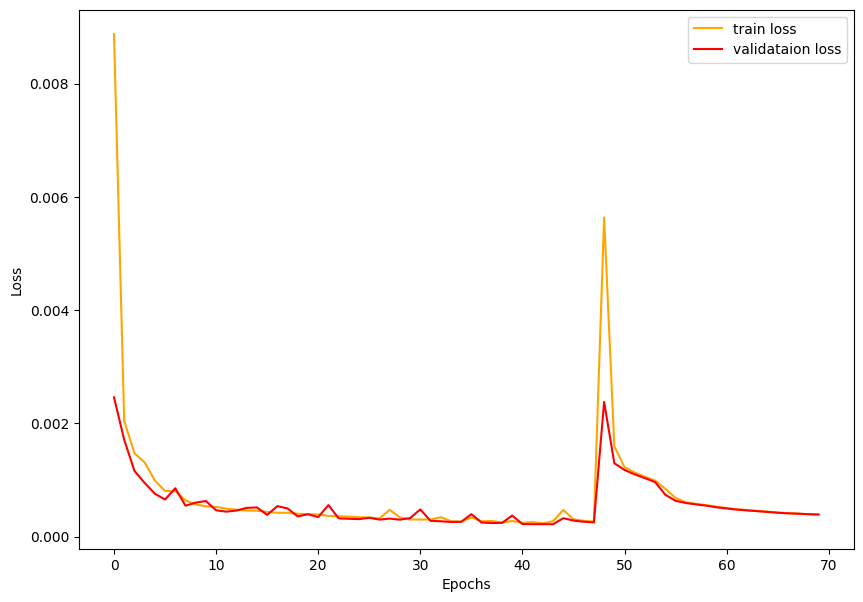

Saving model...


In [22]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), './outputs/model.pth')

## Printing Results

In [23]:
def print_results(path):
    try:
        # Open the image file
        img = Image.open(path)
        
        # Print the image
        img.show()
    except Exception as e:
        print("An error occurred:", e)

# Provide the path to the image file
Car = "D:\\Final Project\\New folder\\input\\sharp\\1ca1155083156d72_jpg.rf.f69458ccf7481ccdd8833b28b4a83f7a.jpg" 
Number_plate = "D:\\Final Project\\outputs\\saved_images\\sharp0.jpg"
Blurred = "D:\\Final Project\\outputs\\saved_images\\blur0.jpg"
Deblurred = "D:\\Final Project\\outputs\\saved_images\\val_deblurred52.jpg"

In [24]:
#Original Image
print_results(Car)

In [25]:
#Number Plate Detected
print_results(Number_plate)

In [26]:
#Number Plate Blurred
print_results(Blurred)

In [27]:
#Number Plate Deblurred
print_results(Deblurred)

## Deleting the data after execution to work on more images

In [28]:
out_dir = "../outputs/saved_images"
def delete_images(dir):
    for filename in os.listdir(dir):
        file_path = os.path.join(dir, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

delete_images(src_dir)
delete_images(dst_dir)
delete_images(out_dir)